* [9.2.4. Example: Therapeutic touch](#9.2.4.-Example:-Therapeutic-touch)
* [9.5.1. Example: Baseball batting abilities by position](#9.5.1.-Example:-Baseball-batting-abilities-by-position)
* [Exercise 9.1](#Exercise-9.1)
* [Exercise 9.2](#Exercise-9.2)

## 9.2.4. Example: Therapeutic touch

Python version of `Jags-Ydich-XnomSsubj-MbernBetaOmegaKappa-Example.R`

In [1]:
import numpy as np
import pandas as pd

# set matplotlib inline so pymc3 plays nicely with jupyter
%matplotlib inline
import pymc3 as pm

import matplotlib.pyplot as plt
plt.style.use('ggplot')

### load data

In [2]:
data_df = pd.read_csv('../datasets/TherapeuticTouchData.csv')

data_df.head(5)

,y,s
0,1,S01
1,0,S01
2,0,S01
3,0,S01
4,0,S01


In [3]:
data = data_df.groupby('s')['y'].apply(list)
data

s
S01    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
S02    [0, 0, 0, 1, 0, 0, 1, 0, 0, 0]
S03    [0, 0, 0, 0, 0, 1, 0, 0, 1, 1]
S04    [0, 1, 1, 0, 1, 0, 0, 0, 0, 0]
S05    [0, 1, 0, 0, 0, 1, 0, 0, 1, 0]
S06    [0, 0, 0, 1, 1, 0, 0, 0, 1, 0]
S07    [0, 0, 1, 0, 0, 1, 1, 0, 0, 0]
S08    [0, 1, 1, 0, 0, 1, 0, 0, 0, 0]
S09    [1, 0, 1, 0, 0, 0, 0, 0, 1, 0]
S10    [0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
S11    [0, 1, 0, 1, 0, 0, 0, 1, 1, 0]
S12    [0, 1, 0, 0, 0, 0, 0, 1, 1, 1]
S13    [1, 0, 1, 1, 1, 0, 0, 0, 0, 0]
S14    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
S15    [1, 0, 0, 1, 0, 0, 0, 1, 1, 0]
S16    [0, 1, 1, 1, 0, 0, 0, 1, 0, 1]
S17    [0, 1, 1, 0, 1, 0, 0, 1, 0, 1]
S18    [1, 1, 0, 1, 1, 0, 1, 0, 0, 0]
S19    [1, 0, 1, 1, 1, 1, 0, 0, 0, 0]
S20    [0, 0, 1, 0, 1, 1, 1, 0, 0, 1]
S21    [1, 0, 0, 1, 1, 1, 0, 0, 1, 0]
S22    [0, 1, 1, 0, 0, 1, 0, 1, 1, 0]
S23    [1, 1, 1, 0, 0, 0, 1, 1, 1, 0]
S24    [1, 0, 0, 1, 1, 1, 0, 0, 1, 1]
S25    [1, 0, 0, 1, 0, 1, 1, 1, 1, 1]
S26    [1, 1, 1, 1, 1, 0, 1, 0, 0, 1]
S27    [0,

### Sample the priors on omega and kappa

In [4]:
with pm.Model() as model:
    # define priors the top level parameters
    omega = pm.Beta('omega', 1, 1, transform=None)
    kappa = pm.Gamma('kappa', 1.105125 , 0.1051249, transform=None)
    
    step = pm.Metropolis()
    trace = pm.sample(500, step=step, njobs=4, progressbar=False) # burn in
    trace = pm.sample(50000, step=step, start=trace[-1], njobs=4)

 [-----------------100%-----------------] 50000 of 50000 complete in 18.9 sec

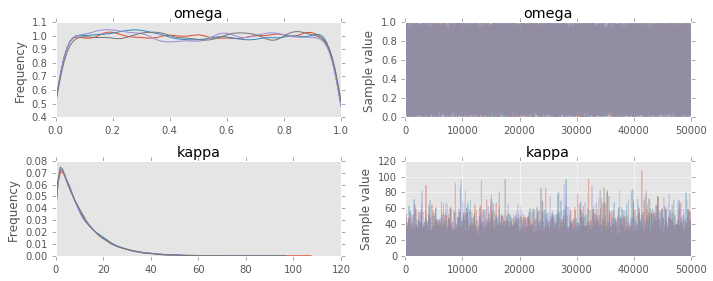

In [5]:
axs = pm.traceplot(trace, figsize=(10,4), varnames=['omega', 'kappa'])

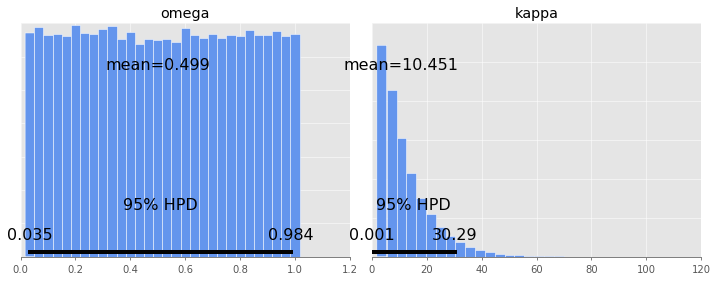

In [6]:
axs = pm.plot_posterior(trace, figsize=(10,4), color='cornflowerblue', varnames=['omega', 'kappa'])

### Build the hierarchical model 

In [7]:
z_observ = data.apply(sum).values
N_observ = data.apply(len).values

with pm.Model() as model:
    # define priors on the top level parameters
    omega = pm.Beta('omega', 1, 1, transform=None)
    kappa = pm.Gamma('kappa', 1.105125 , 0.1051249, transform=None)
    
    # parameters for Beta distribution (the prior on subject's theta)
    alpha = omega*kappa + 1
    beta = (1-omega)*kappa + 1
    
    # define the prior on theta
    theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=len(z_observ), transform=None)
    
    # define the likelihood
    z = pm.Binomial('z', n=N_observ, p=theta, observed=z_observ)

    # use Metropolis sampling as it's the fastest among the other 2
    step = pm.Metropolis(tune_interval=1000)
    # step = pm.Slice()
    # step = None
    
    trace = pm.sample(2000, step=step, njobs=4) # burn in
    trace = pm.sample(200000, step=step, start=trace[-1], njobs=4)

 [-----------------100%-----------------] 200000 of 200000 complete in 150.5 sec

### Analyze results

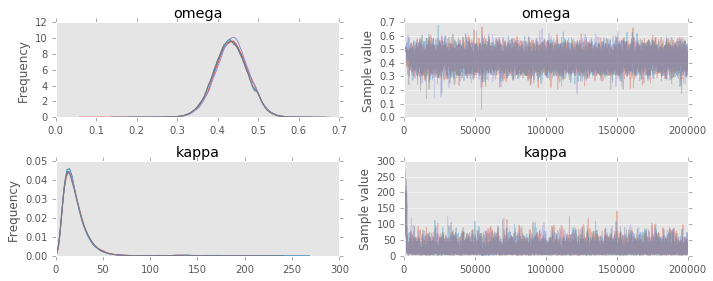

In [8]:
axs = pm.traceplot(trace, figsize=(10,4), varnames=['omega', 'kappa'])

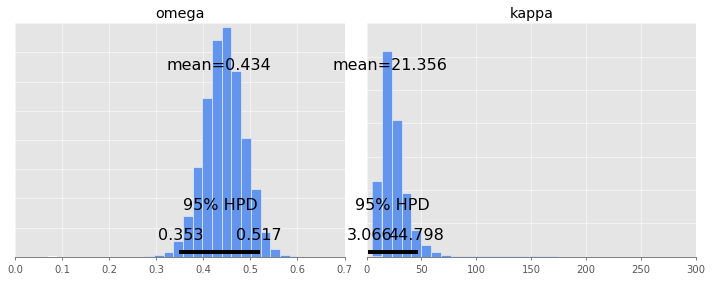

In [9]:
axs = pm.plot_posterior(trace, figsize=(10,4), color='cornflowerblue', varnames=['omega', 'kappa'])

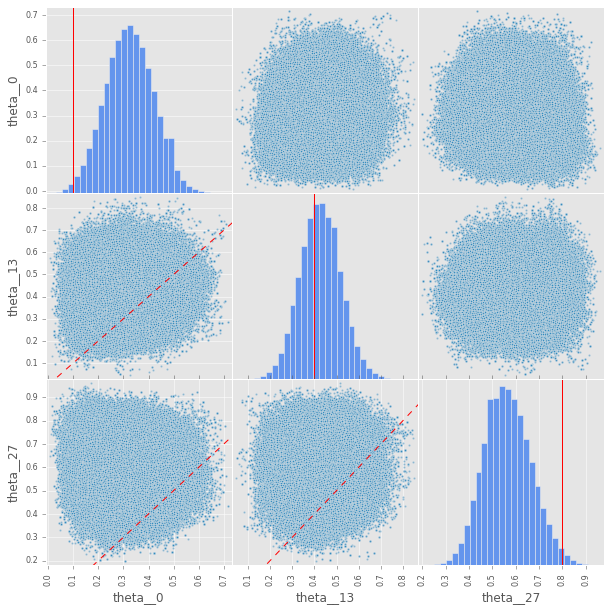

In [10]:
trace_df = pm.trace_to_dataframe(trace)
trace_df = trace_df[['theta__0', 'theta__13', 'theta__27']]
axs = pd.scatter_matrix(trace_df, figsize=(10,10), diagonal='hist',
                        hist_kwds={'bins':30, 'normed':True, 'color':'cornflowerblue'});

ax = axs[0,0]
ax.vlines(np.array(data['S01']).mean(), ax.get_ylim()[0], ax.get_ylim()[1], color='r')

ax = axs[1,1]
ax.vlines(np.array(data['S14']).mean(), ax.get_ylim()[0], ax.get_ylim()[1], color='r')

ax = axs[2,2]
ax.vlines(np.array(data['S28']).mean(), ax.get_ylim()[0], ax.get_ylim()[1], color='r')

axs[1,0].plot([0,1], [0,1], color='red', linestyle='--')
axs[2,0].plot([0,1], [0,1], color='red', linestyle='--')
axs[2,1].plot([0,1], [0,1], color='red', linestyle='--')

plt.show()

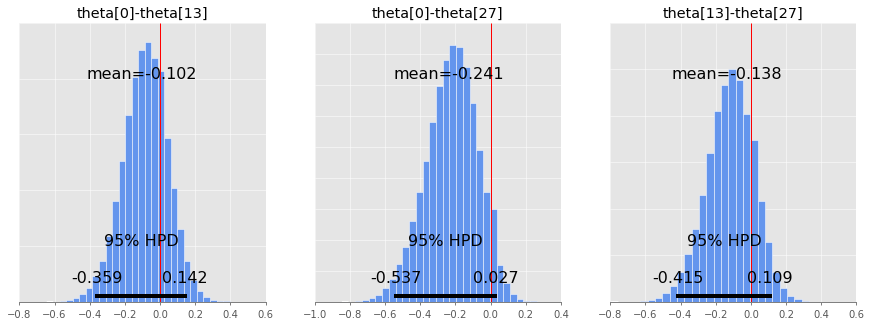

In [11]:
f, axs = plt.subplots(1, 3, figsize=(15,5))

ax = axs[0]
pm.plot_posterior(trace_df['theta__0'].values - trace_df['theta__13'].values,
                 ax=ax, color='cornflowerblue')
ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], color='r')
ax.set_title('theta[0]-theta[13]')

ax = axs[1]
pm.plot_posterior(trace_df['theta__0'].values - trace_df['theta__27'].values,
                 ax=ax, color='cornflowerblue')
ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], color='r')
ax.set_title('theta[0]-theta[27]')

ax = axs[2]
pm.plot_posterior(trace_df['theta__13'].values - trace_df['theta__27'].values,
                 ax=ax, color='cornflowerblue')
ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], color='r')
ax.set_title('theta[13]-theta[27]')

plt.show()

## 9.5.1. Example: Baseball batting abilities by position

EXTENDING THE HIERARCHY: SUBJECTS WITHIN CATEGORIES

### Load data

In [23]:
data_df = pd.read_csv('../datasets/BattingAverage.csv')
data_df.head(5)

,Player,PriPos,Hits,AtBats,PlayerNumber,PriPosNumber
0,Fernando Abad,Pitcher,1,7,1,1
1,Bobby Abreu,Left Field,53,219,2,7
2,Tony Abreu,2nd Base,18,70,3,4
3,Dustin Ackley,2nd Base,137,607,4,4
4,Matt Adams,1st Base,21,86,5,3


In [24]:
print('number of players: %d' % data_df.shape[0])

number of players: 948


### Build the model in pymc3

In [25]:
# pymc3 can't handle this dataset, so reduce number of samples
data_df = data_df.head(5)

# convert categorical positions to numerical values
positions, pos_encoding = np.unique(data_df['PriPos'], return_inverse=True)
data_df['PriPos'] = pos_encoding

with pm.Model() as model:
    # define priors on the top level parameters
    omegaO = pm.Beta('omegaO', 1, 1, transform=None)
    kappaO = pm.Gamma('kappaO', 0.01 , 0.01, transform=None)
    
    # define categories' variables
    alphaO = omegaO*kappaO + 1
    betaO = (1-omegaO)*kappaO + 1
    
    n_cat = len(data_df['PriPos'].unique())
    omega = pm.Beta('omega', alphaO, betaO, shape=n_cat, transform=None)
    kappa = pm.Gamma('kappa', 0.01 , 0.01, shape=n_cat, transform=None)
    
    # define subjects' variables
    for i, row in data_df[['PriPos', 'Hits', 'AtBats']].iterrows():
        s = row['PriPos']
        N_observ = row['AtBats']
        z_observ = row['Hits']
        
        alpha = omega[s]*kappa[s] + 1
        beta = (1-omega[s])*kappa[s] + 1
        
        theta_name = 'theta_%d' % (i+1)
        theta = pm.Beta(theta_name, alpha, beta, transform=None)
        
        z_name = 'z_%d' % (i+1)
        z = pm.Binomial(z_name, n=N_observ, p=theta, observed=z_observ)
    
    # use Metropolis sampling as it's the fastest among the other 2
    step = pm.Metropolis(tune_interval=1000)
    # step = pm.Slice()
    # step = None
    
    trace = pm.sample(2000, step=step, njobs=4) # burn in
    trace = pm.sample(50000, step=step, start=trace[-1], njobs=4)

 [-----------------100%-----------------] 50000 of 50000 complete in 284.8 sec

### Analyze results

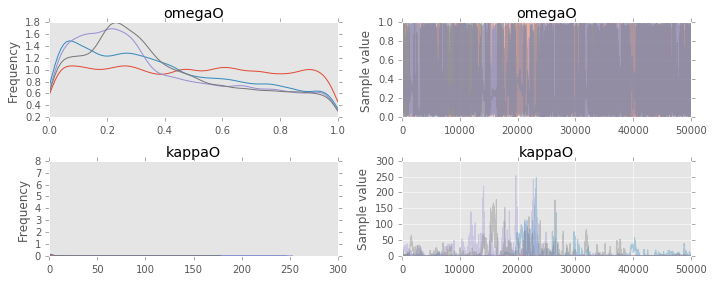

In [26]:
axs = pm.traceplot(trace, figsize=(10,4), varnames=['omegaO', 'kappaO'])

^^ It does not seem like pymc3 converged the chains

**Note**: Unfortunately, pymc3 could not handle even a significantly reduced dataset of baseball players. In the following sections there is the same model implemented in pystan

### Build the model in pystan

In [27]:
import pystan as ps
import seaborn as sns
from dbda2e_utils import plotPost

In [38]:
# reload data
data_df = pd.read_csv('../datasets/BattingAverage.csv')

# convert categorical positions to numerical values
positions, pos_encoding = np.unique(data_df['PriPos'], return_inverse=True)
data_df['PriPos'] = pos_encoding

In [39]:
model_code = """
data {
    int<lower=0> n_cat;    
    int<lower=0> n_subj;
    int<lower=0> categories[n_subj];
    int<lower=0> observations[n_subj];
    int<lower=0> successes[n_subj];
}
parameters {
    real<lower=0,upper=1> omegaO;
    real<lower=0.01> kappaO;
    
    real<lower=0,upper=1> omegas[n_cat];
    real<lower=0.01> kappas[n_cat];
    
    real<lower=0,upper=1> thetas[n_subj];
}
transformed parameters {
    real alphaO;
    real betaO;
    
    real alphas[n_cat];
    real betas[n_cat];    

    alphaO = omegaO*kappaO + 1;
    betaO = (1-omegaO)*kappaO + 1;
    
    for (c in 1:n_cat) {
        alphas[c] = omegas[c]*kappas[c] + 1;
        betas[c] = (1-omegas[c])*kappas[c] + 1;
    }
}
model {
    int cat;
    
    omegaO ~ beta(1, 1);
    kappaO ~ gamma(0.01 , 0.01);
    
    for (c in 1:n_cat) {
        omegas[c] ~ beta(alphaO, betaO);
        kappas[c] ~ gamma(0.01 , 0.01);
    }
    
    for (s in 1:n_subj) {
        cat = categories[s] + 1; // indexing starts with 1
        thetas[s] ~ beta(alphas[cat], betas[cat]);
        successes[s] ~ binomial(observations[s], thetas[s]);
    }
}
"""

data = {
    'n_cat': len(data_df['PriPos'].unique()),
    'n_subj': data_df.shape[0],
    'categories': data_df['PriPos'].values,
    'observations': data_df['AtBats'].values,
    'successes': data_df['Hits'].values
}

fit = ps.stan(model_code=model_code, data=data, iter=11000, warmup=1000, chains=4)

In [41]:
samples = fit.extract(permuted=False, inc_warmup=False)
samples.shape

(10000, 4, 989)

### Analyze Results

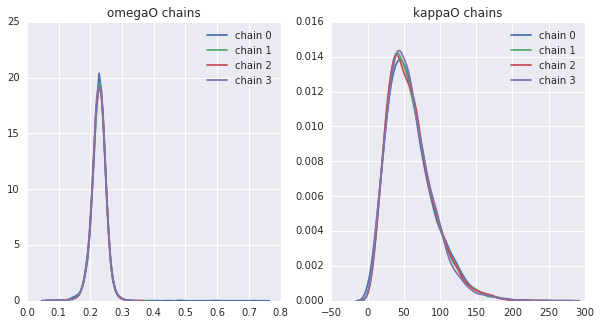

In [42]:
# Check MCMC conversion
f, ax = plt.subplots(1,2,figsize=(10,5))
for chain_id in range(4):
    smpl = samples[:, chain_id, fit.flatnames.index('omegaO')]
    label = 'chain %d' % chain_id
    sns.kdeplot(smpl, label=label, ax=ax[0])
ax[0].set_title('omegaO chains')

for chain_id in range(4):
    smpl = samples[:, chain_id, fit.flatnames.index('kappaO')]
    label = 'chain %d' % chain_id
    sns.kdeplot(smpl, label=label, ax=ax[1])
ax[1].set_title('kappaO chains')
plt.legend()
plt.show()

In [43]:
# convert to DataFrame
param_samples = samples[:, :, :-1] # exclude log prob (the last on the params dimension)
n_samples, n_chains, n_params = param_samples.shape
param_samples = param_samples.reshape((n_samples*n_chains, n_params)) # join all chains

samples_df = pd.DataFrame(param_samples.reshape((n_samples*n_chains, n_params)), columns=fit.flatnames)

In [44]:
def plot_mcmc_posterior(data, titles, xlabels):
    points1, points2 = data
    title1, title2 = titles
    xlabel1, xlabel2 = xlabels
    
    f, axs = plt.subplots(2,2,figsize=(10,10))

    # marginal posterior for param1
    plotPost(points1, axs[0,0], title=title1, xlabel=xlabel1)

    # marginal posterios for param1 - param2
    ax = axs[0,1]
    title = '%s - %s' % (title1, title2)
    xlabel = '%s - %s' % (xlabel1, xlabel2)
    plotPost(points1-points2, ax, title=title, xlabel=xlabel1)
    ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], color='r', linestyle='--')

    # marginal posterior for 2
    plotPost(points2, axs[1,1], title=title2, xlabel=xlabel2)

    ax = axs[1,0]
    ax.scatter(points1, points2)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.plot([0,1], [0,1], color='red', linestyle='--')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(title1)
    ax.set_ylabel(title2)
    return

In [45]:
def analyze_pairwise(param1, param2, param_type):
    if param_type == 'positions':
        param_name1 = '%s[%d]' % ('omegas', positions.tolist().index(param1))
        param_name2 = '%s[%d]' % ('omegas', positions.tolist().index(param2))
    else:
        # players
        param_name1 = '%s[%d]' % ('thetas', data_df['Player'].tolist().index(param1))
        param_name2 = '%s[%d]' % ('thetas', data_df['Player'].tolist().index(param2))
        
    plot_mcmc_posterior(data=[samples_df[param_name1], samples_df[param_name2]],
                        titles=[param1, param2],
                        xlabels=[param_name1, param_name2])

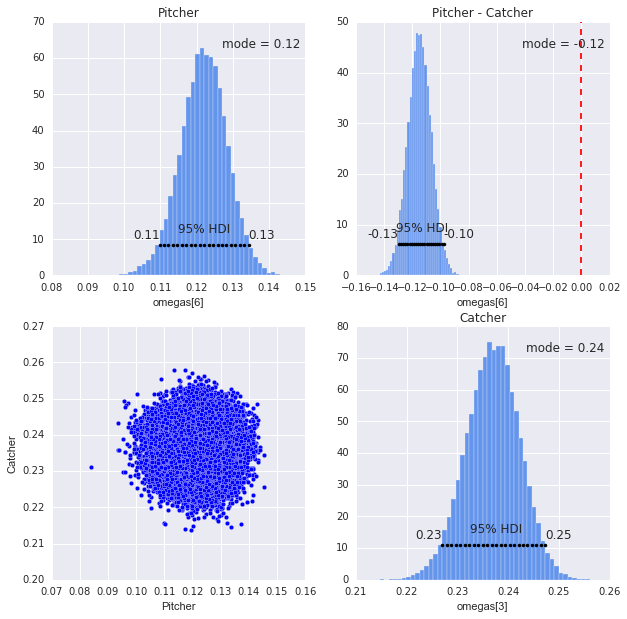

In [46]:
analyze_pairwise('Pitcher', 'Catcher', 'positions')

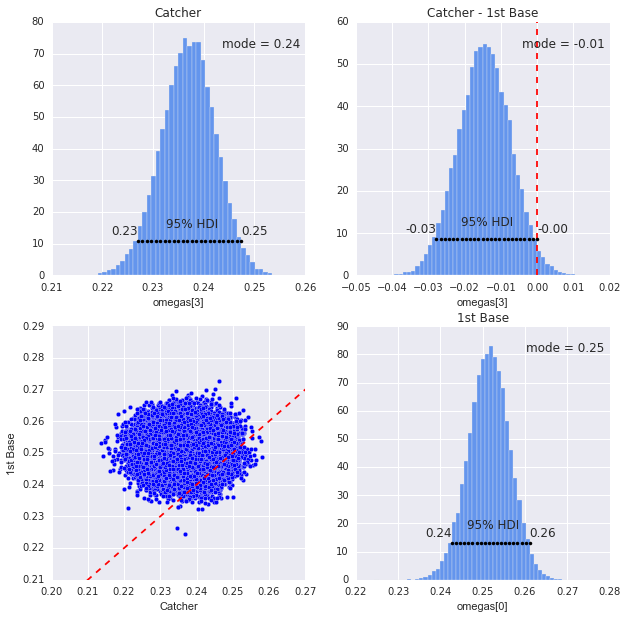

In [47]:
analyze_pairwise('Catcher', '1st Base', 'positions')

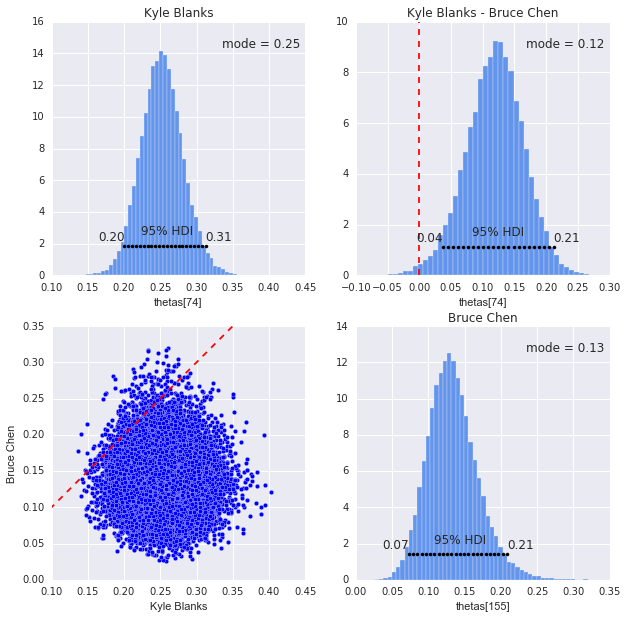

In [48]:
analyze_pairwise('Kyle Blanks', 'Bruce Chen', 'players')

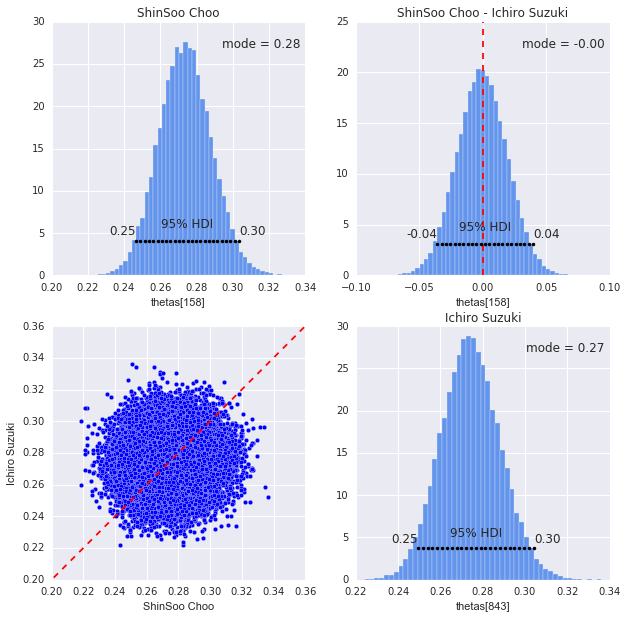

In [49]:
analyze_pairwise('ShinSoo Choo', 'Ichiro Suzuki', 'players')

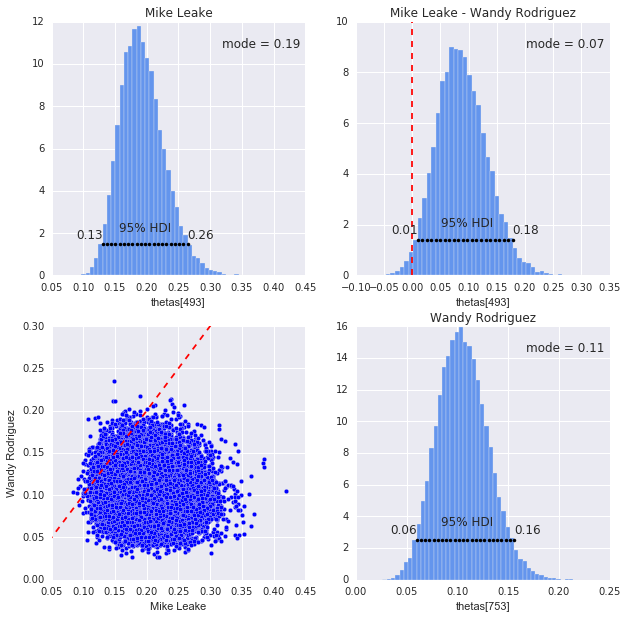

In [50]:
analyze_pairwise('Mike Leake', 'Wandy Rodriguez', 'players')

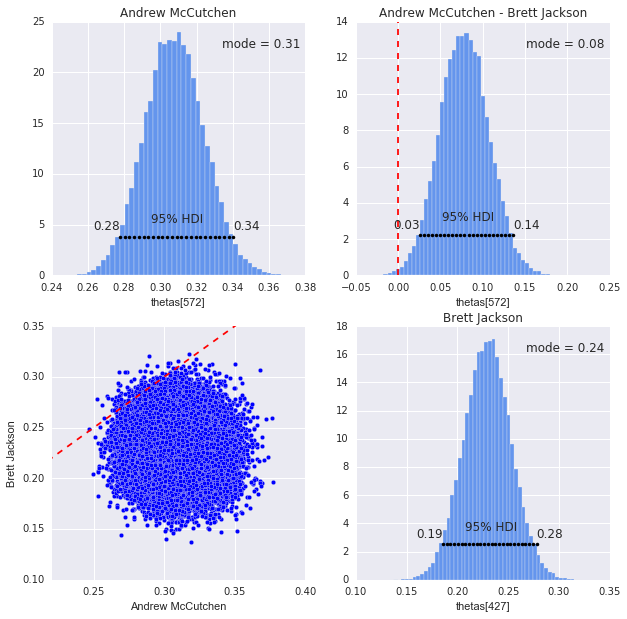

In [51]:
analyze_pairwise('Andrew McCutchen', 'Brett Jackson', 'players')

## Exercise 9.1

**Purpose**: Try di erent priors on κ to explore the role of κ in shrinkage.

In [2]:
myu = 1 # mean
omega = 1 # mode
std = 10 # standard deviation

### Part A

In [3]:
shape1 = myu * myu / (std * std)
rate1 = myu / (std * std)
shape1, rate1

(0.01, 0.01)

In [4]:
rate2 = (omega + np.sqrt(omega * omega + 4 * std * std)) / (2 * std * std)
shape2 = 1 + omega * rate2
shape2, rate2

(1.1051249219725039, 0.10512492197250393)

### Part B

In [55]:
from scipy.stats import gamma as gammad
def gamma_(x, shape, rate):
    rv = gammad(shape, scale = 1.0/rate)
    return rv.pdf(x)

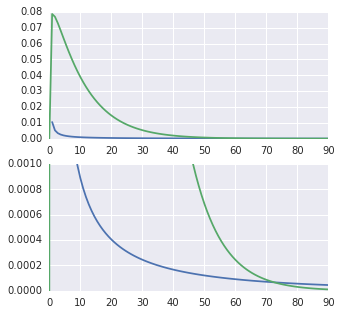

In [56]:
f, axs = plt.subplots(2, 1, figsize=(5,5))

x = np.linspace(0, 90, num=100)

ax = axs[0]
ax.plot(x, gamma_(x, shape1, rate1))
ax.plot(x, gamma_(x, shape2, rate2))

ax = axs[1]
ax.plot(x, gamma_(x, shape1, rate1))
ax.plot(x, gamma_(x, shape2, rate2))
ax.set_ylim([0,0.001])
plt.show()

### Part C

In [58]:
data_df = pd.read_csv('../datasets/TherapeuticTouchData.csv')
data = data_df.groupby('s')['y'].apply(list)

z_observ = data.apply(sum).values
N_observ = data.apply(len).values

with pm.Model() as model:
    # define priors on the top level parameters
    omega = pm.Beta('omega', 1, 1, transform=None)
    kappa = pm.Gamma('kappa', shape1 , rate1, transform=None)
    
    # parameters for Beta distribution (the prior on subject's theta)
    alpha = omega*kappa + 1
    beta = (1-omega)*kappa + 1
    
    # define the prior on theta
    theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=len(z_observ), transform=None)
    
    # define the likelihood
    z = pm.Binomial('z', n=N_observ, p=theta, observed=z_observ)

    step = None    
    trace = pm.sample(2000, step=step, njobs=4) # burn in
    trace = pm.sample(20000, step=step, start=trace[-1], njobs=4)

Assigned NUTS to omega
Assigned NUTS to kappa
Assigned NUTS to theta
 [-----------------100%-----------------] 2000 of 2000 complete in 37.9 secAssigned NUTS to omega
Assigned NUTS to kappa
Assigned NUTS to theta
 [-----------------100%-----------------] 20000 of 20000 complete in 488.8 sec

(0, 250)

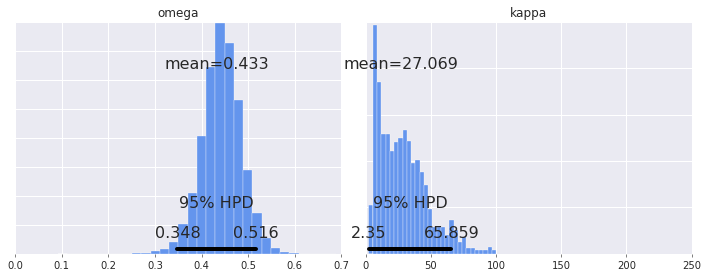

In [59]:
axs = pm.plot_posterior(trace, figsize=(10,4), color='cornflowerblue', varnames=['omega', 'kappa'])
axs[1].set_xlim([0,250])

In [60]:
data_df = pd.read_csv('../datasets/TherapeuticTouchData.csv')
data = data_df.groupby('s')['y'].apply(list)

z_observ = data.apply(sum).values
N_observ = data.apply(len).values

with pm.Model() as model:
    # define priors on the top level parameters
    omega = pm.Beta('omega', 1, 1, transform=None)
    kappa = pm.Gamma('kappa', shape2 , rate2, transform=None)
    
    # parameters for Beta distribution (the prior on subject's theta)
    alpha = omega*kappa + 1
    beta = (1-omega)*kappa + 1
    
    # define the prior on theta
    theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=len(z_observ), transform=None)
    
    # define the likelihood
    z = pm.Binomial('z', n=N_observ, p=theta, observed=z_observ)

    step = None    
    trace = pm.sample(2000, step=step, njobs=4) # burn in
    trace = pm.sample(20000, step=step, start=trace[-1], njobs=4)

Assigned NUTS to omega
Assigned NUTS to kappa
Assigned NUTS to theta
 [-----------------100%-----------------] 2000 of 2000 complete in 10.3 secAssigned NUTS to omega
Assigned NUTS to kappa
Assigned NUTS to theta
 [-----------------100%-----------------] 20000 of 20000 complete in 98.8 sec

(0, 100)

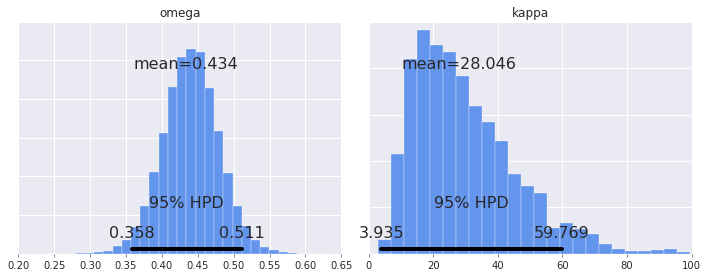

In [61]:
axs = pm.plot_posterior(trace, figsize=(10,4), color='cornflowerblue', varnames=['omega', 'kappa'])
axs[1].set_xlim([0,100])

## Exercise 9.2

**Purpose**: Examine the prior on θs implied by the prior constants at higher levels.

In [ ]:
data_df = pd.read_csv('../datasets/TherapeuticTouchData.csv')
data = data_df.groupby('s')['y'].apply(list)

z_observ = data.apply(sum).values
N_observ = data.apply(len).values

with pm.Model() as model:
    # define priors on the top level parameters
    omega = pm.Beta('omega', 1, 1, transform=None)
    kappa = pm.Gamma('kappa', shape1 , rate1, transform=None)
    
    # parameters for Beta distribution (the prior on subject's theta)
    alpha = omega*kappa + 1
    beta = (1-omega)*kappa + 1
    
    # define the prior on theta
    theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=len(z_observ), transform=None)
    
    # define the likelihood
    # z = pm.Binomial('z', n=N_observ, p=theta, observed=z_observ)

    step = None
    trace = pm.sample(2000, step=step) # burn in
    trace = pm.sample(20000, step=step, start=trace[-1])

In [ ]:
trace_df = pm.trace_to_dataframe(trace)
trace_df = trace_df[['theta__0', 'theta__13', 'theta__27']]
axs = pd.scatter_matrix(trace_df, figsize=(10,10), diagonal='hist',
                        hist_kwds={'bins':30, 'normed':True, 'color':'cornflowerblue'});

ax = axs[0,0]
ax.vlines(np.array(data['S01']).mean(), ax.get_ylim()[0], ax.get_ylim()[1], color='r')

ax = axs[1,1]
ax.vlines(np.array(data['S14']).mean(), ax.get_ylim()[0], ax.get_ylim()[1], color='r')

ax = axs[2,2]
ax.vlines(np.array(data['S28']).mean(), ax.get_ylim()[0], ax.get_ylim()[1], color='r')

axs[1,0].plot([0,1], [0,1], color='red', linestyle='--')
axs[2,0].plot([0,1], [0,1], color='red', linestyle='--')
axs[2,1].plot([0,1], [0,1], color='red', linestyle='--')

plt.show()

In [ ]:
data_df = pd.read_csv('../datasets/TherapeuticTouchData.csv')
data = data_df.groupby('s')['y'].apply(list)

z_observ = data.apply(sum).values
N_observ = data.apply(len).values

with pm.Model() as model:
    # define priors on the top level parameters
    omega = pm.Beta('omega', 1, 1, transform=None)
    kappa = pm.Gamma('kappa', shape2 , rate2, transform=None)
    
    # parameters for Beta distribution (the prior on subject's theta)
    alpha = omega*kappa + 1
    beta = (1-omega)*kappa + 1
    
    # define the prior on theta
    theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=len(z_observ), transform=None)
    
    # define the likelihood
    # z = pm.Binomial('z', n=N_observ, p=theta, observed=z_observ)

    step = None
    trace = pm.sample(2000, step=step) # burn in
    trace = pm.sample(20000, step=step, start=trace[-1])

In [ ]:
trace_df = pm.trace_to_dataframe(trace)
trace_df = trace_df[['theta__0', 'theta__13', 'theta__27']]
axs = pd.scatter_matrix(trace_df, figsize=(10,10), diagonal='hist',
                        hist_kwds={'bins':30, 'normed':True, 'color':'cornflowerblue'});

ax = axs[0,0]
ax.vlines(np.array(data['S01']).mean(), ax.get_ylim()[0], ax.get_ylim()[1], color='r')

ax = axs[1,1]
ax.vlines(np.array(data['S14']).mean(), ax.get_ylim()[0], ax.get_ylim()[1], color='r')

ax = axs[2,2]
ax.vlines(np.array(data['S28']).mean(), ax.get_ylim()[0], ax.get_ylim()[1], color='r')

axs[1,0].plot([0,1], [0,1], color='red', linestyle='--')
axs[2,0].plot([0,1], [0,1], color='red', linestyle='--')
axs[2,1].plot([0,1], [0,1], color='red', linestyle='--')

plt.show()